# Performance evaluation of different pyroaring versions

We measured the performance of many bitmap operations with different pyroaring functions. The experiment was carried on one AWS `c6i.large` instance (Intel Ice Lake, namely a Xeon Platinum 8375C) running on Ubuntu.

The experiment was carried by running the `version_benchmark.sh` script, which uses the `benchmark.py` program. More precisely, this code was executed:
```
wget https://raw.githubusercontent.com/Ezibenroc/PyRoaringBitMap/aef969c6512ecd083e98ac065c72a53e969b017f/version_benchmark.sh
nohup bash version_benchmark.sh > output.txt &
```

We tested ten times all the pyroaring versions from `0.3.0` to `0.4.0` in a random order. For each run, we tested three different bitmap densities (0.01, 0.2, 0.99) and all the bitmap operations in a random order. The measure for a given density and operation is repeated 100 times, the average duration is then reported.

Each time, `pyroaring` is installed from Pypi, uisng a pre-compiled wheel.

Note: the bitmaps have $S=1000000$ elements and are randomly and uniformly generated. The density refers to the probability that a given element is chosen. More precisely, with a density $d$, we sampled randomly $S$ elements from the interval $[0,S/d]$. This will affect the kind of container that we are more likely to have. With $d=0.01$, we mostly have array containers, with $d=0.2$ we mostly have bitset containers and with $d=0.99$ we mostly have run containers.

## Loading the data

In [1]:
library(dplyr)
library(ggplot2)
library(repr)
library(readr)

options(repr.plot.width=12, repr.plot.height=8)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
df = read.csv('data/version_evaluation_2023-03-26.csv') %>%
    mutate(density = factor(density)) %>%
    mutate(timestamp = parse_datetime(as.character(timestamp))) %>%
    mutate(pyroaring_version = factor(pyroaring_version, levels=c("0.3.0","0.3.2","0.3.3","0.3.4","0.3.5","0.3.6","0.3.7","0.3.8","0.4.0")))
df %>% head()

,operation,density,size,time,timestamp,nb_calls,pyroaring_version,croaring_version
,<chr>,<fct>,<int>,<dbl>,<dttm>,<int>,<fct>,<chr>
1,selection,0.2,1000000,7.718200e-07,2023-03-26 18:04:55,100,0.3.0,v0.3.1
2,membership test,0.99,1000000,5.199000e-08,2023-03-26 18:04:56,100,0.3.0,v0.3.1
3,range constructor,0.99,1000000,4.734670e-05,2023-03-26 18:04:56,100,0.3.0,v0.3.1
4,membership test,0.01,1000000,6.557000e-08,2023-03-26 18:04:56,100,0.3.0,v0.3.1
5,"""optimized"" conversion to array",0.99,1000000,6.470653e-04,2023-03-26 18:04:57,100,0.3.0,v0.3.1
6,symmetric diference,0.01,1000000,6.794375e-03,2023-03-26 18:04:58,100,0.3.0,v0.3.1


## CRoaring version used by each pyroaring version

In [3]:
df %>%
    select(pyroaring_version, croaring_version) %>%
    unique() %>%
    arrange(pyroaring_version)

pyroaring_version,croaring_version
<fct>,<chr>
0.3.0,v0.3.1
0.3.2,v0.3.2
0.3.3,v0.3.3
0.3.4,v0.7.2
0.3.5,v0.8.1
0.3.6,v0.9.6
0.3.7,v0.9.8
0.3.8,v0.9.9
0.4.0,v1.0.0


## Visualization of the performance

In the next cell, we plot the durations of each operation for all the versions and densities. Each point is the average of 100 measures. The boxes represent a 99% confidence interval for the estimation of the mean, assuming a normal distribution of the points.

Warning: the Y axis always starts at 0, but different scales are used for the different densities and operations.

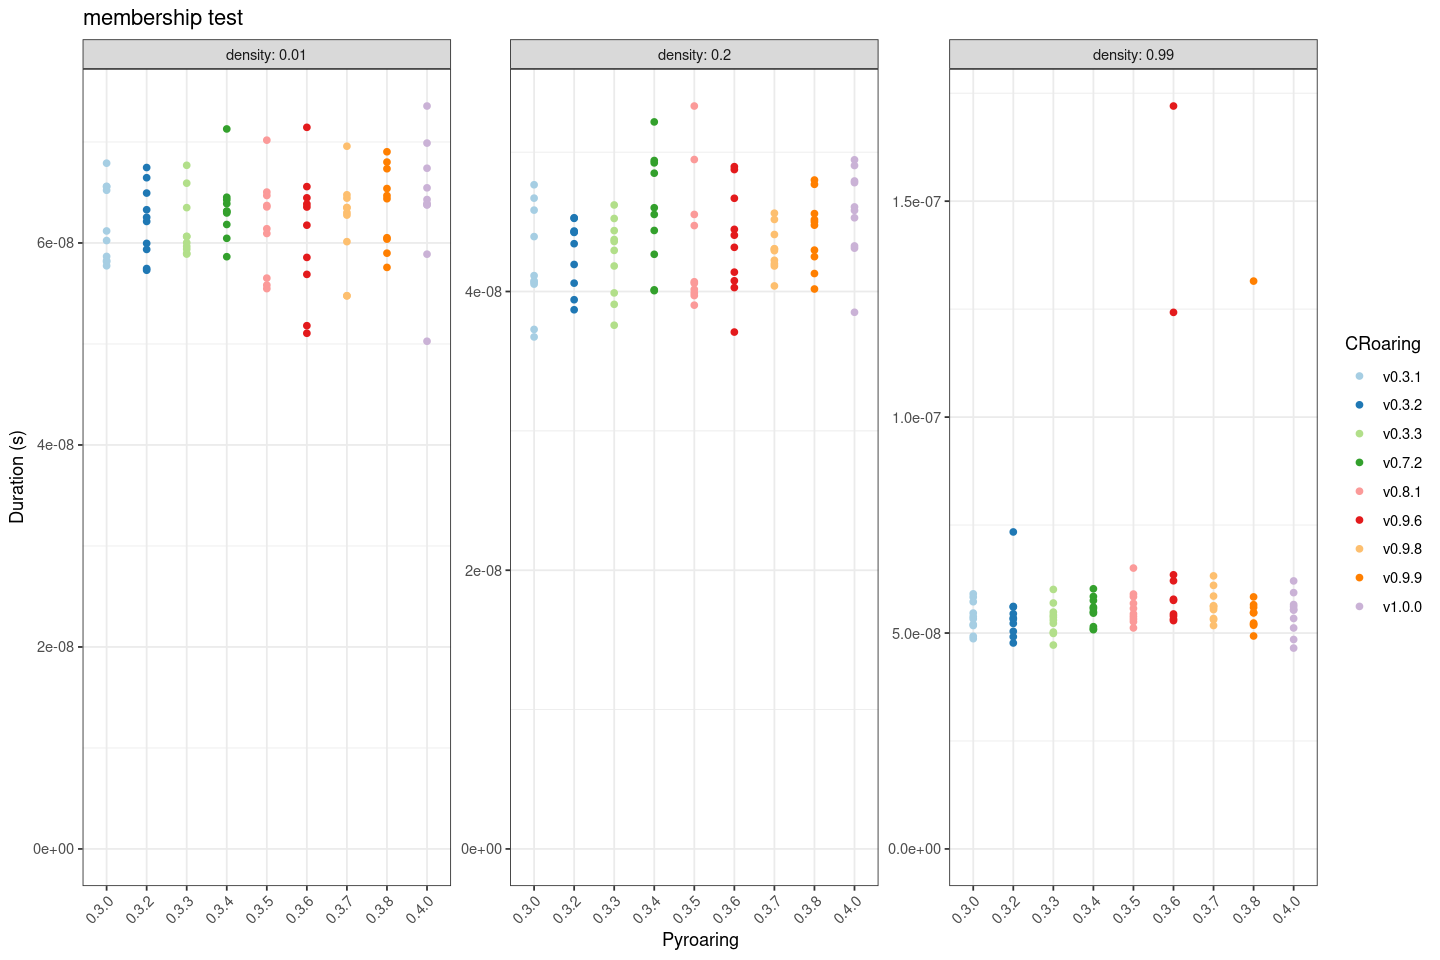

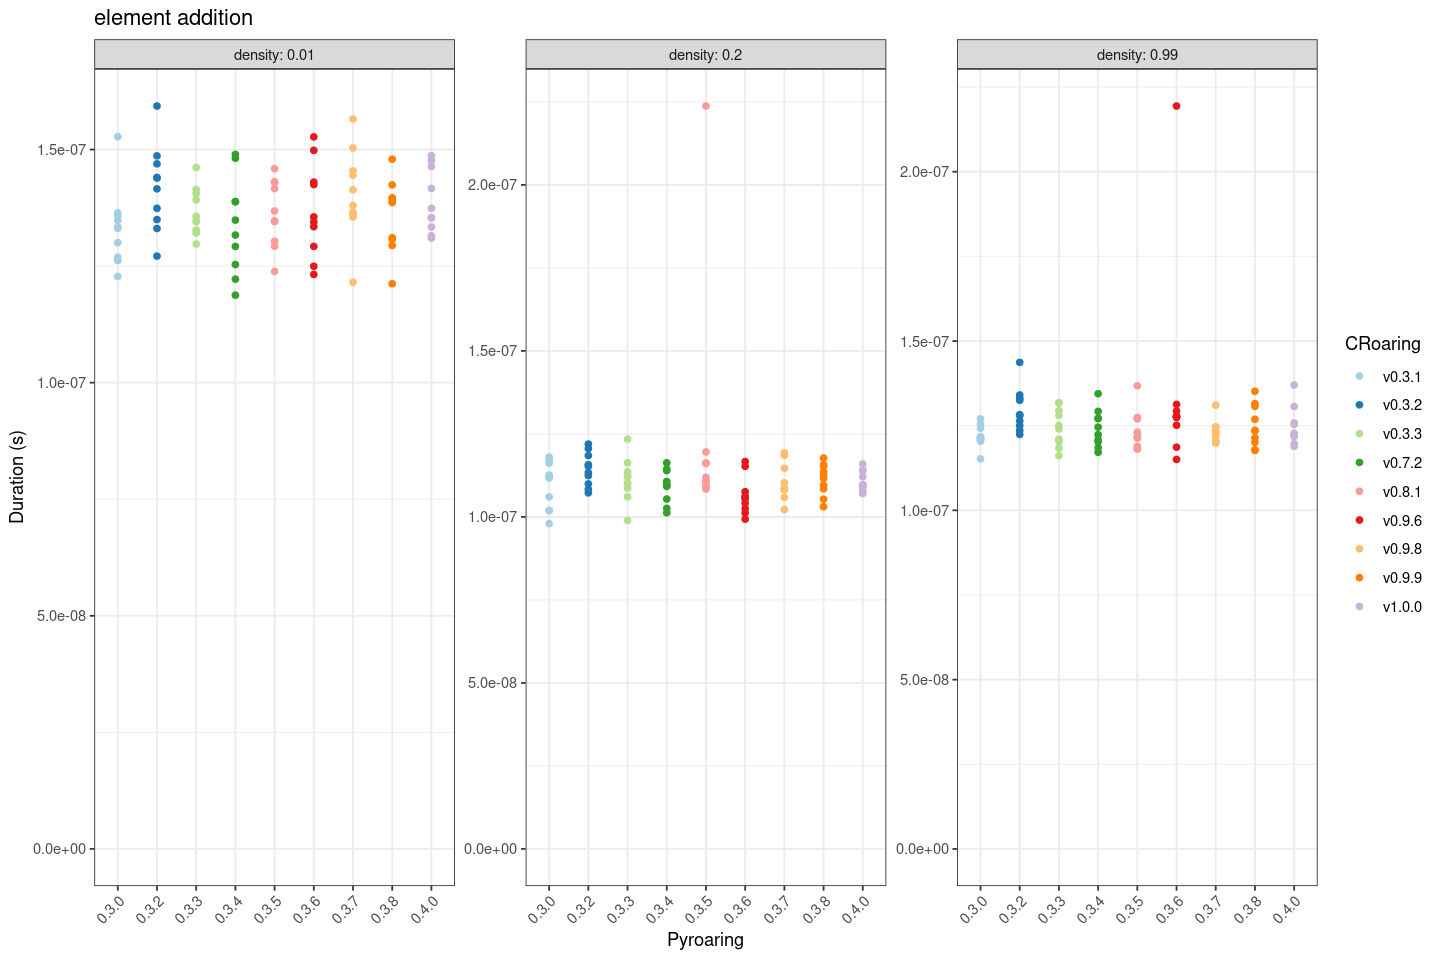

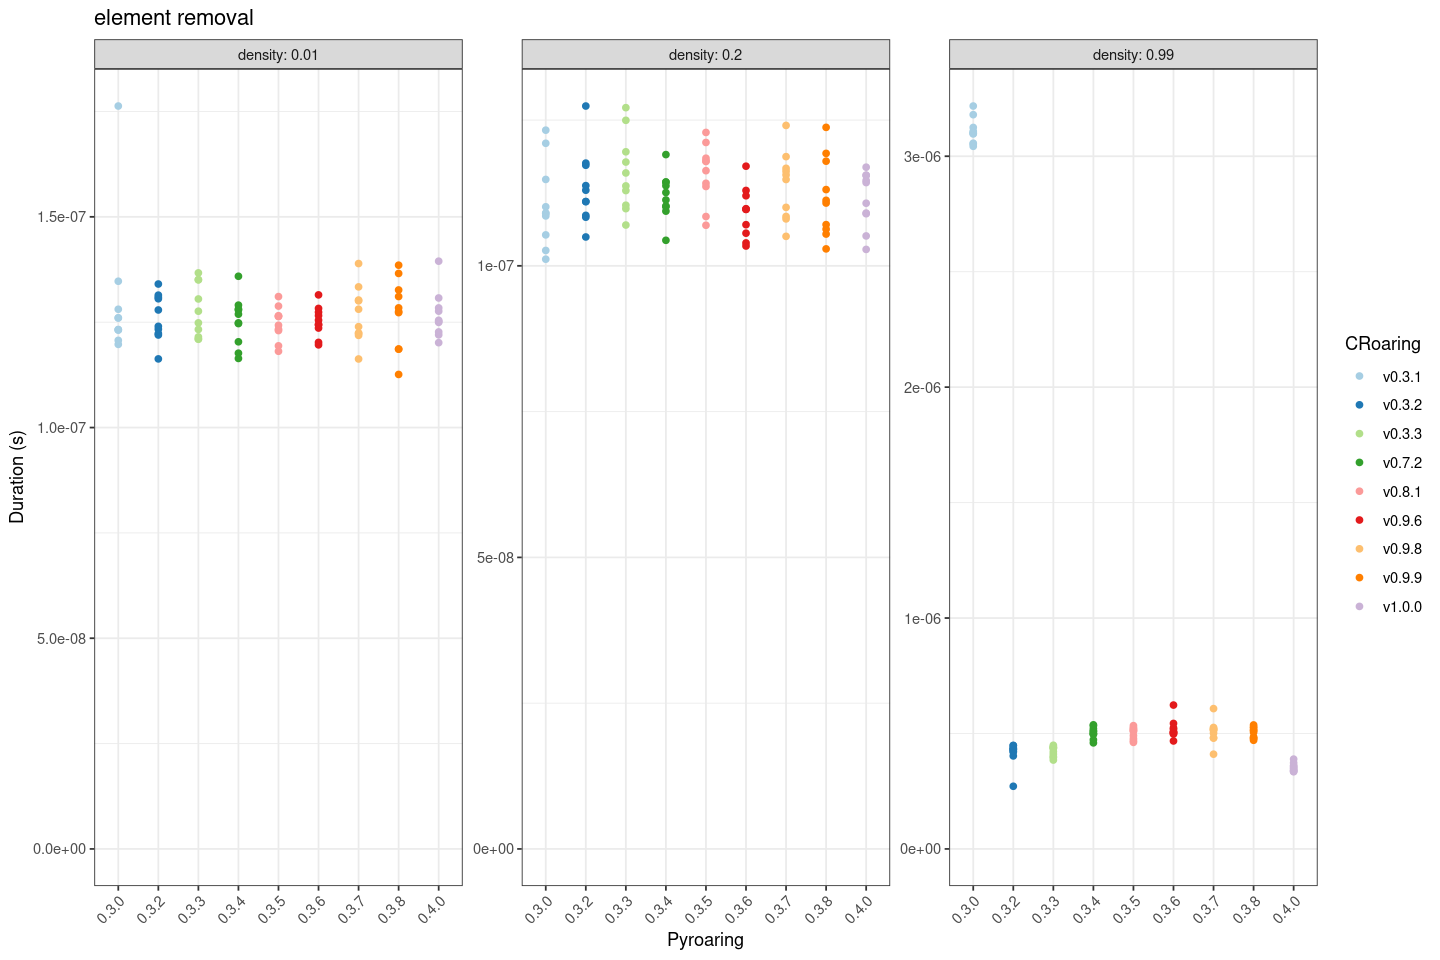

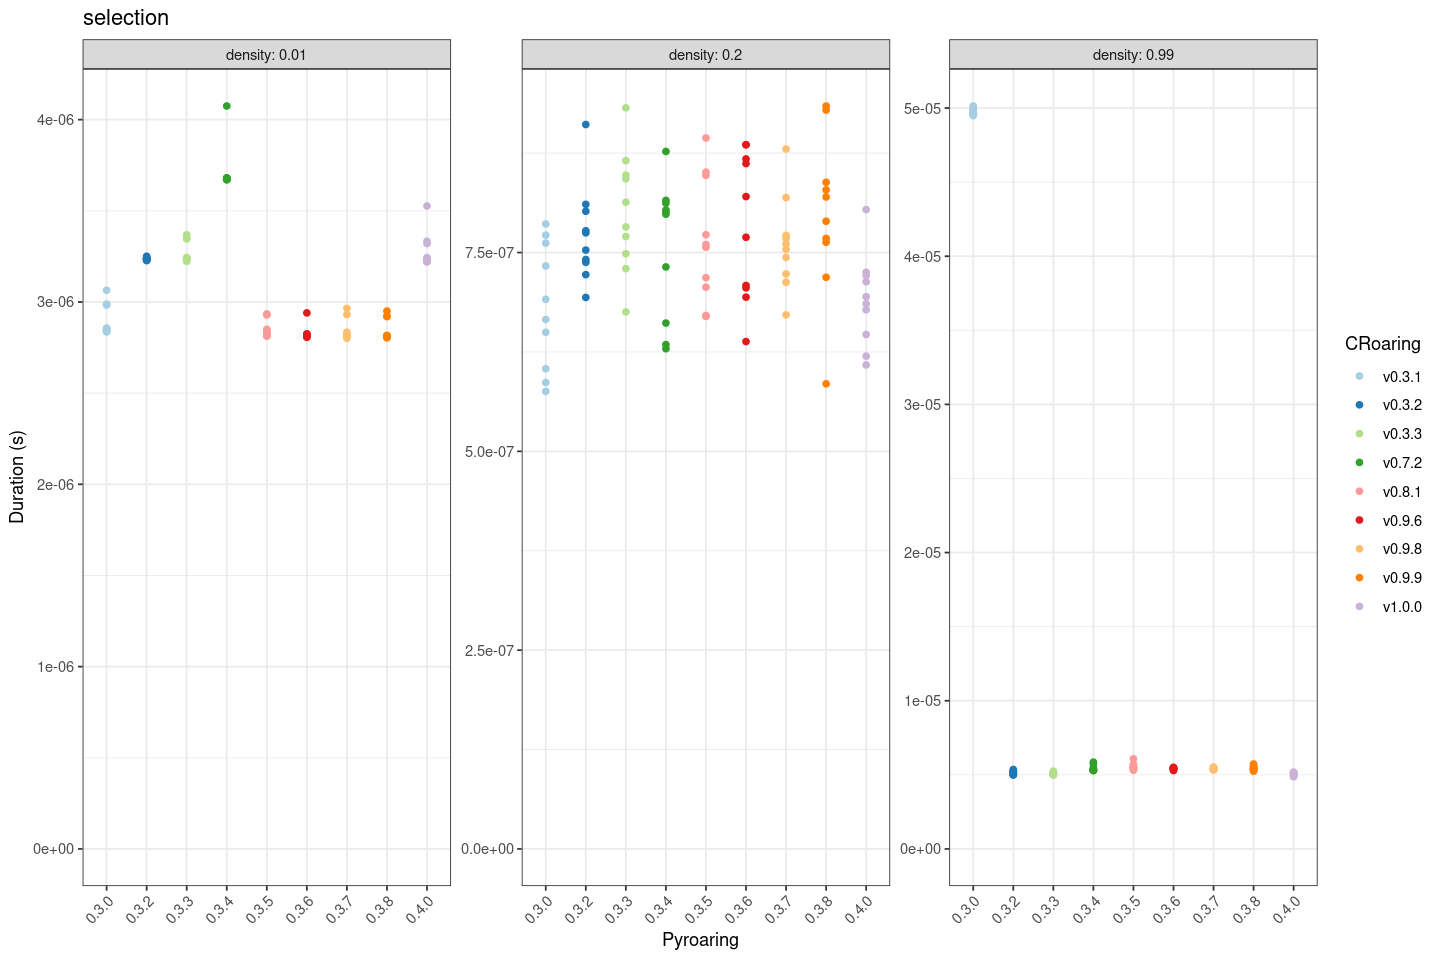

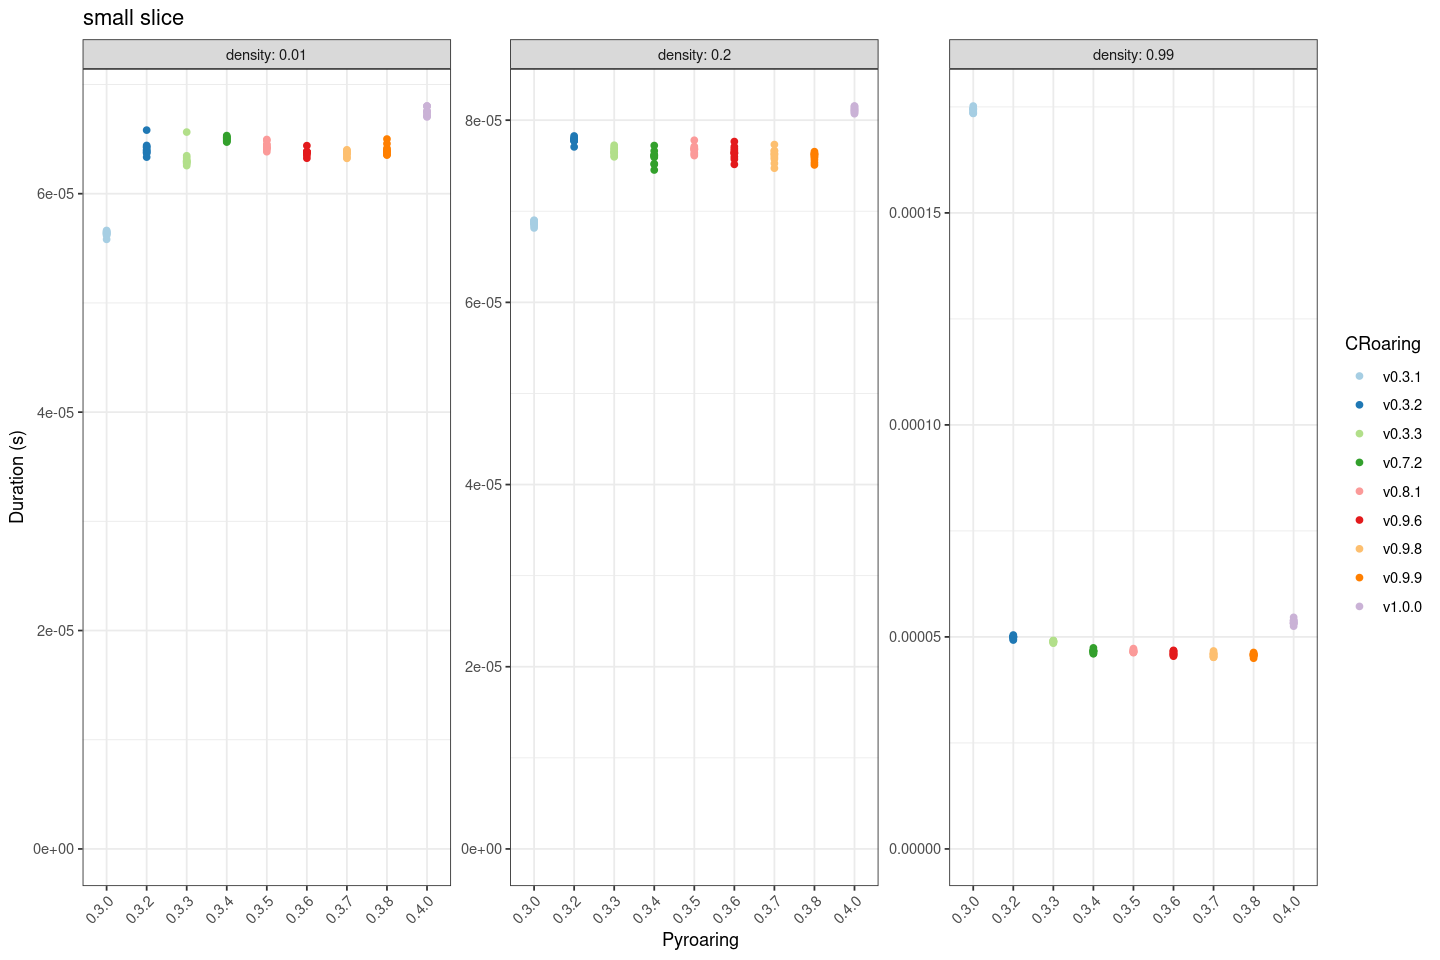

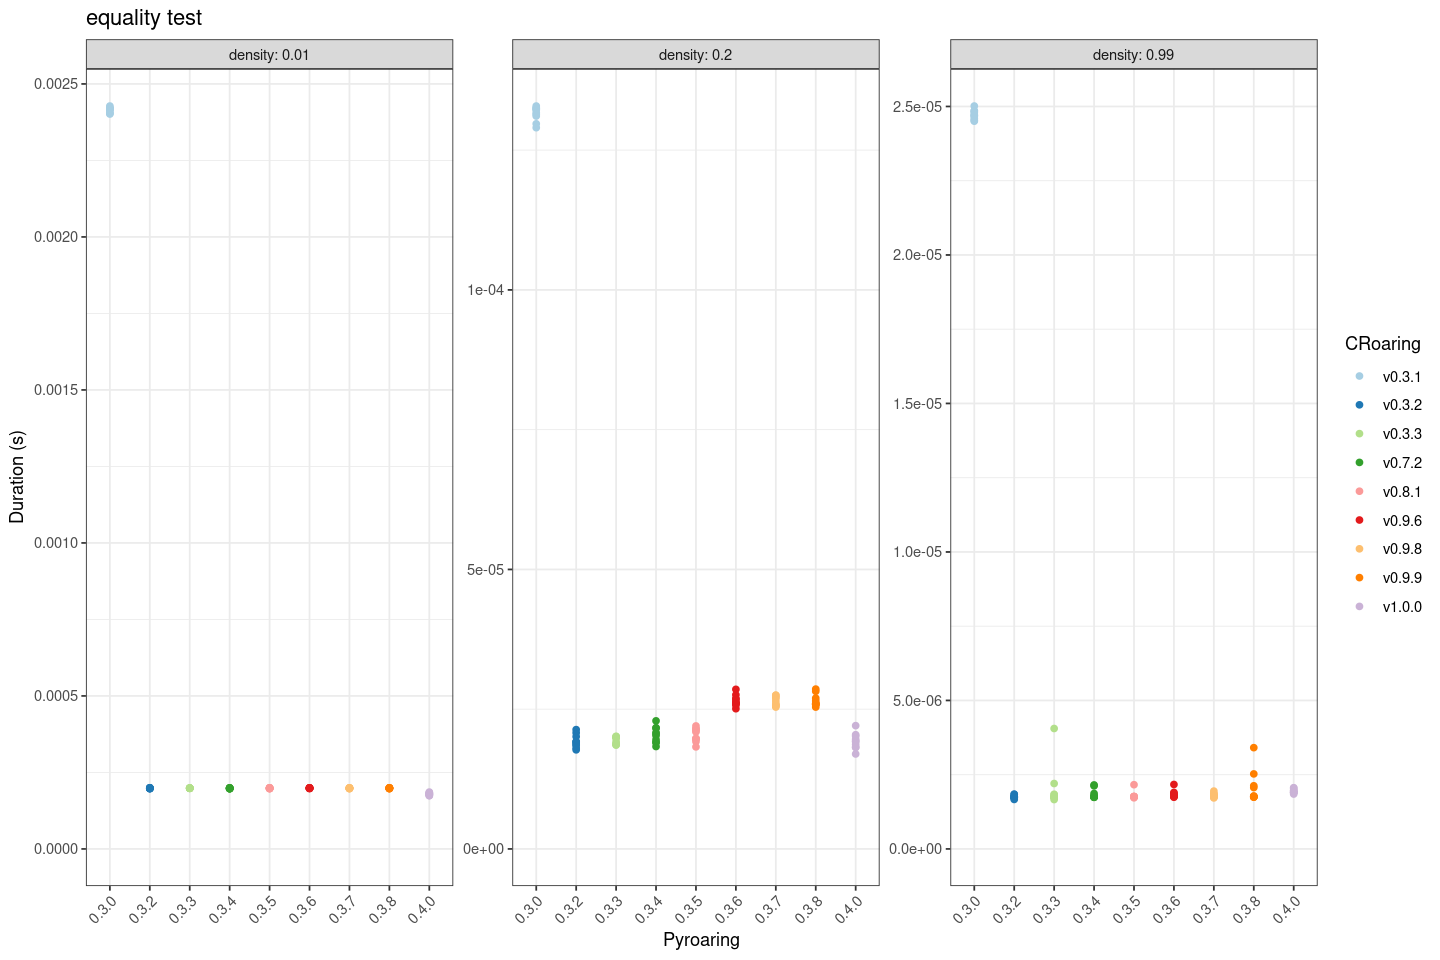

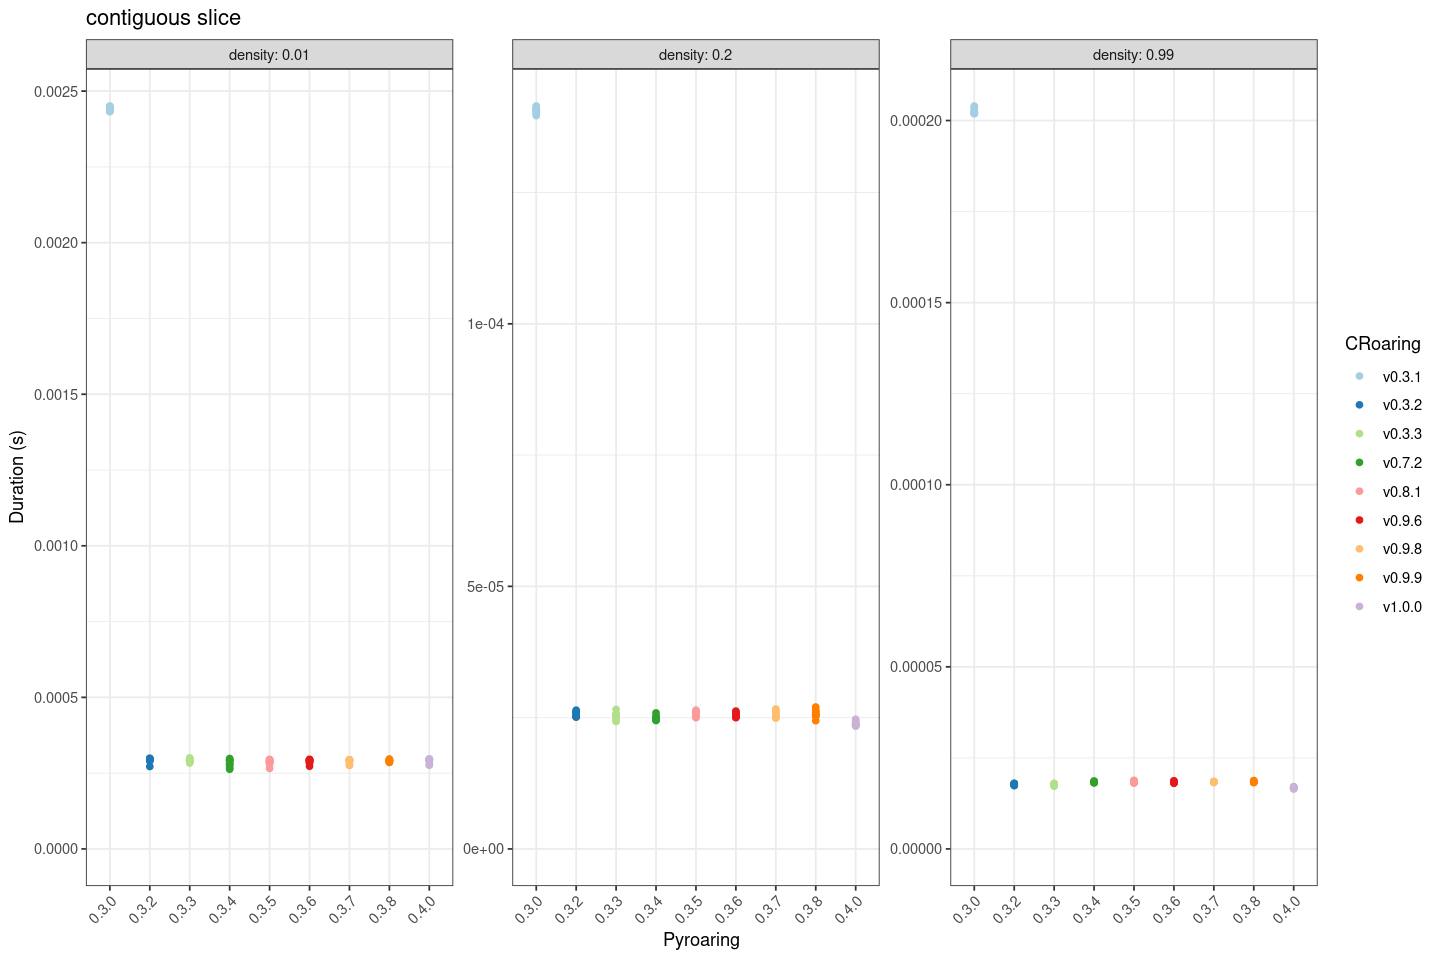

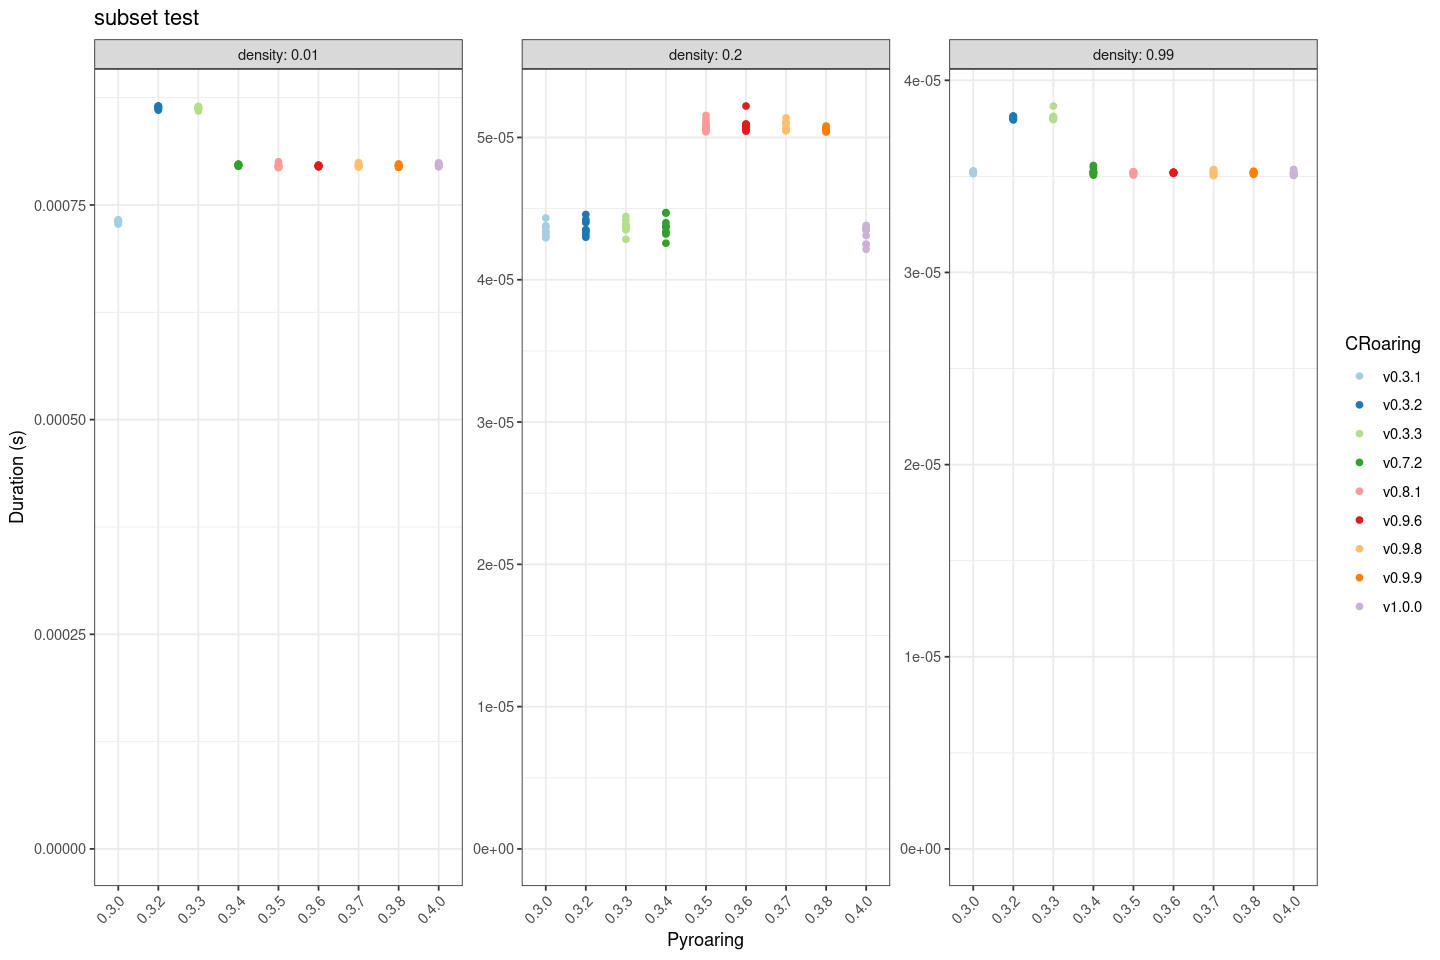

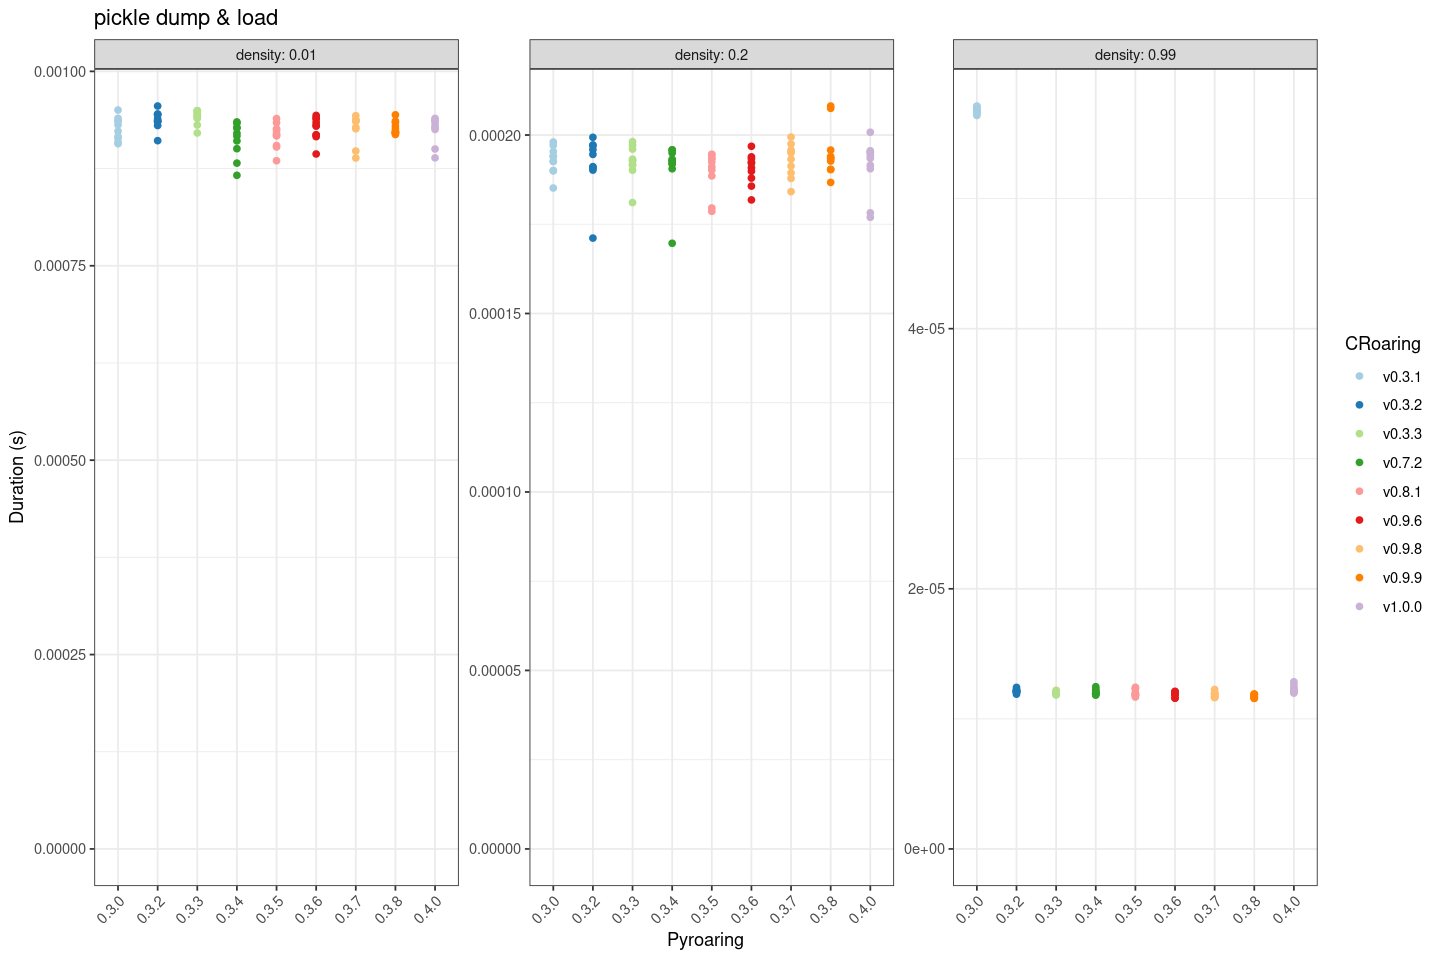

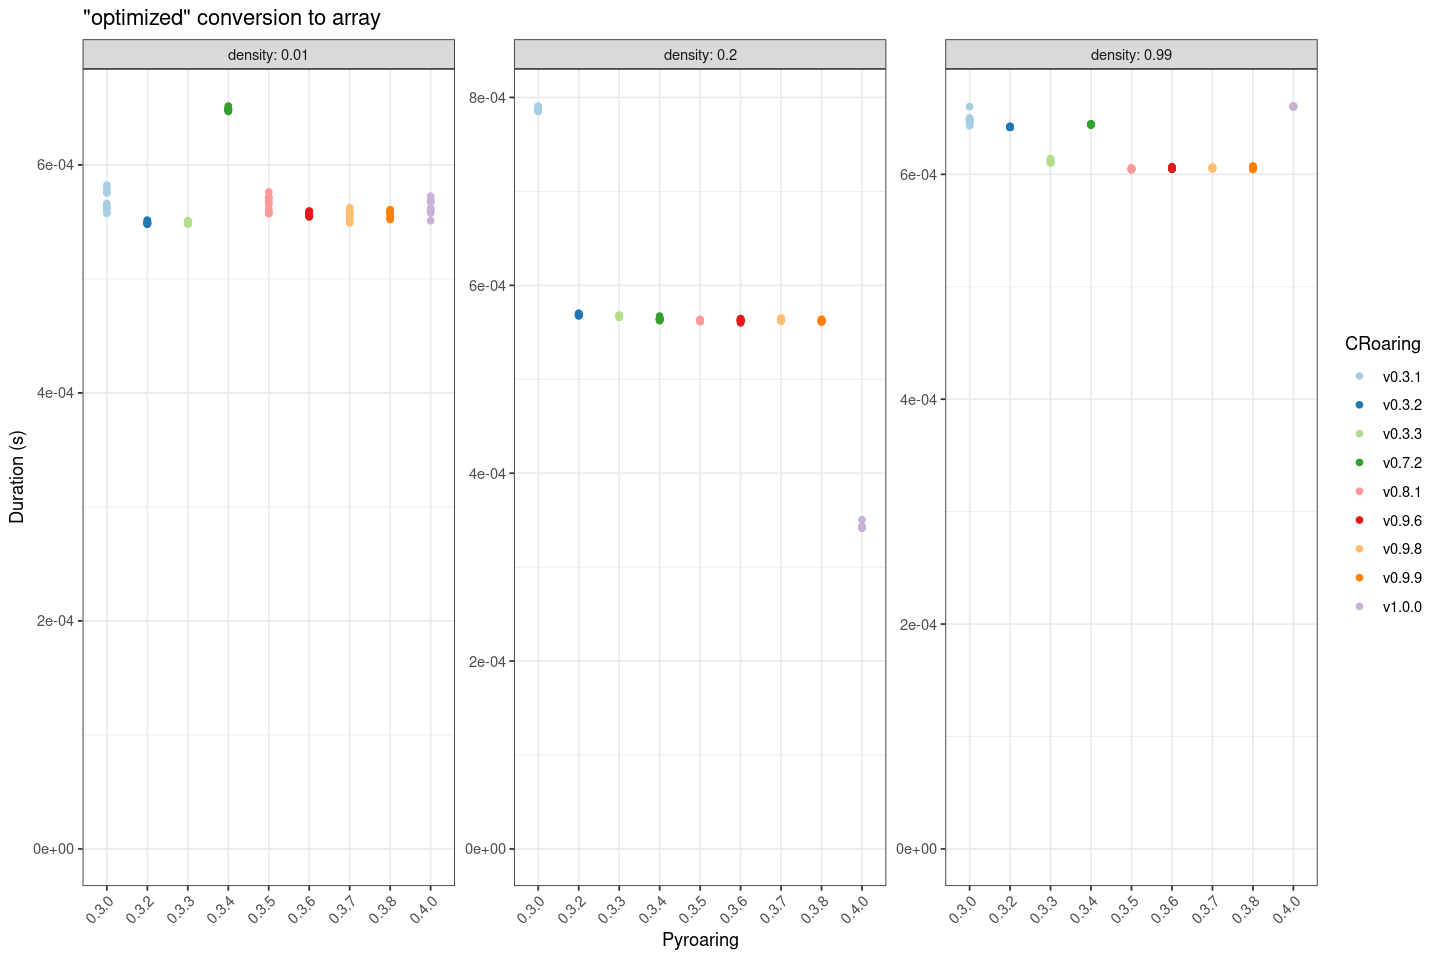

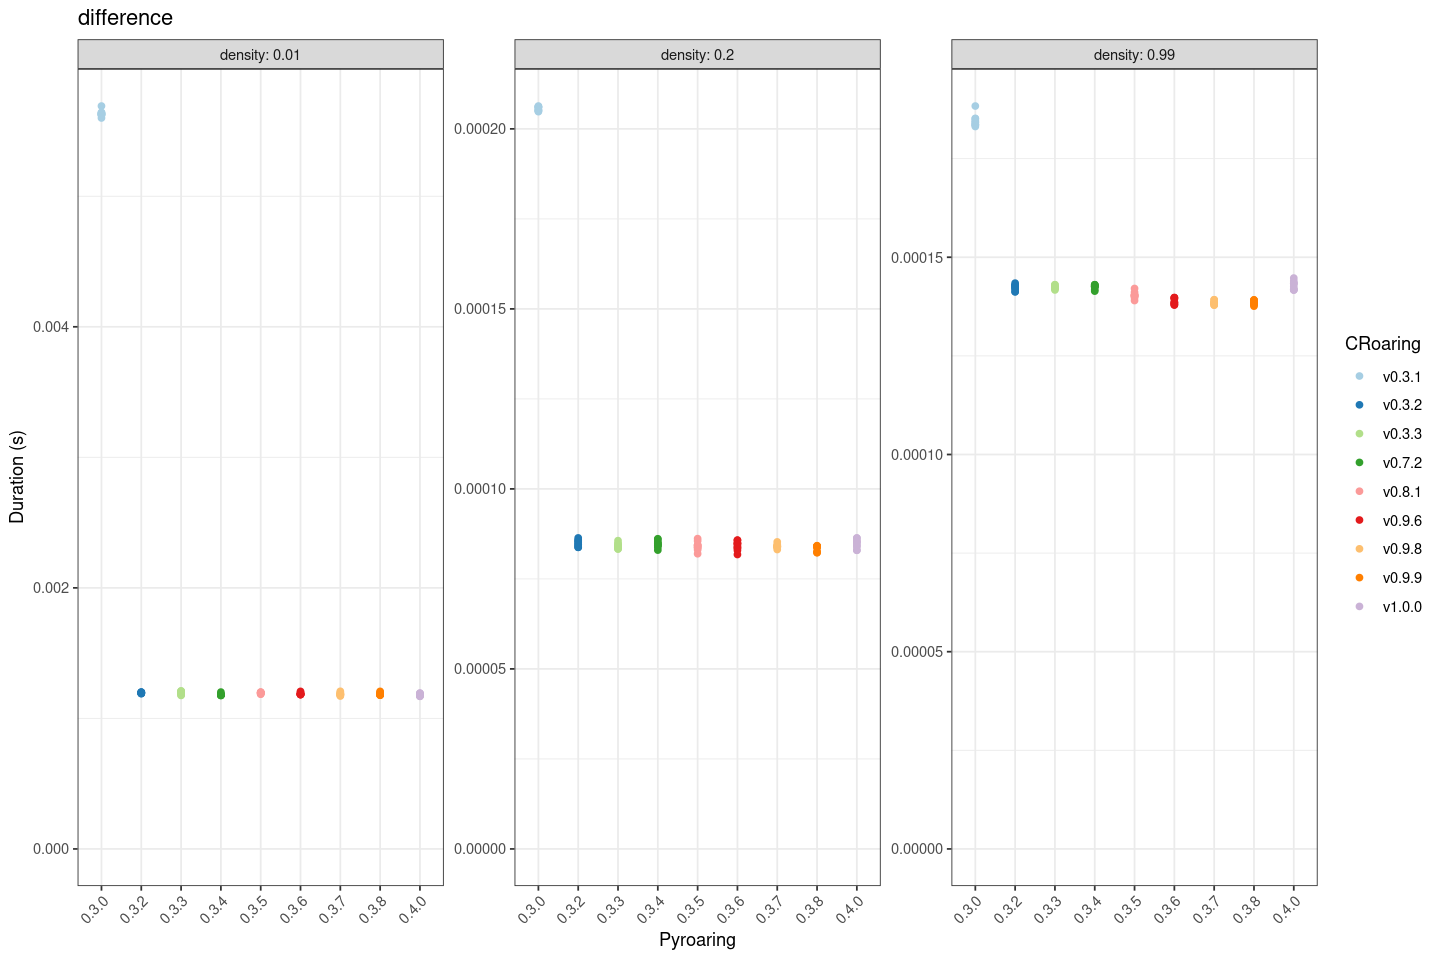

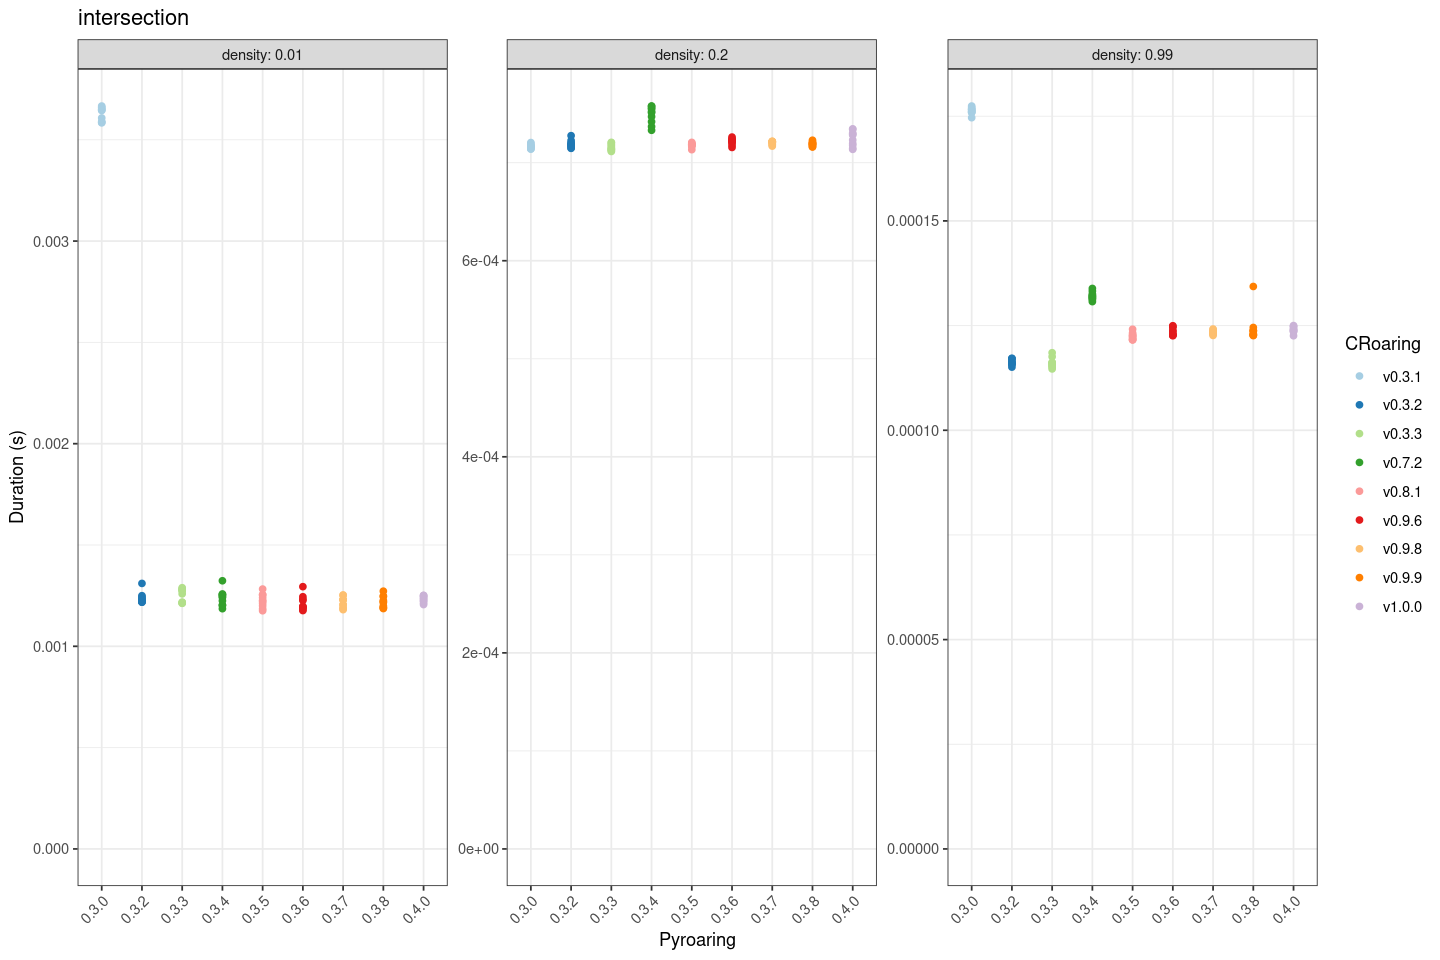

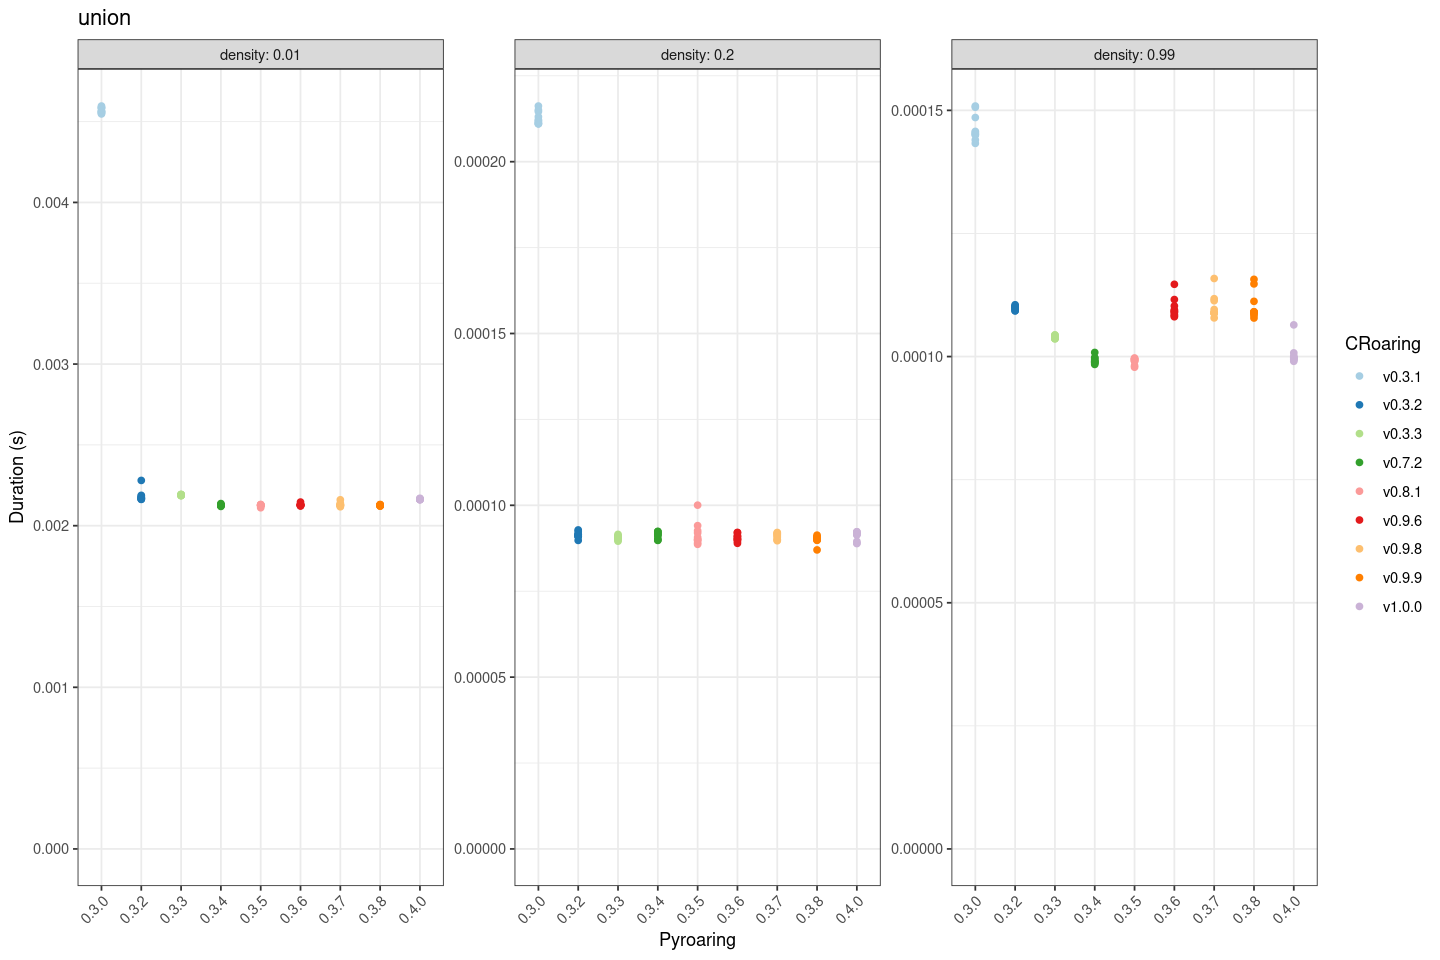

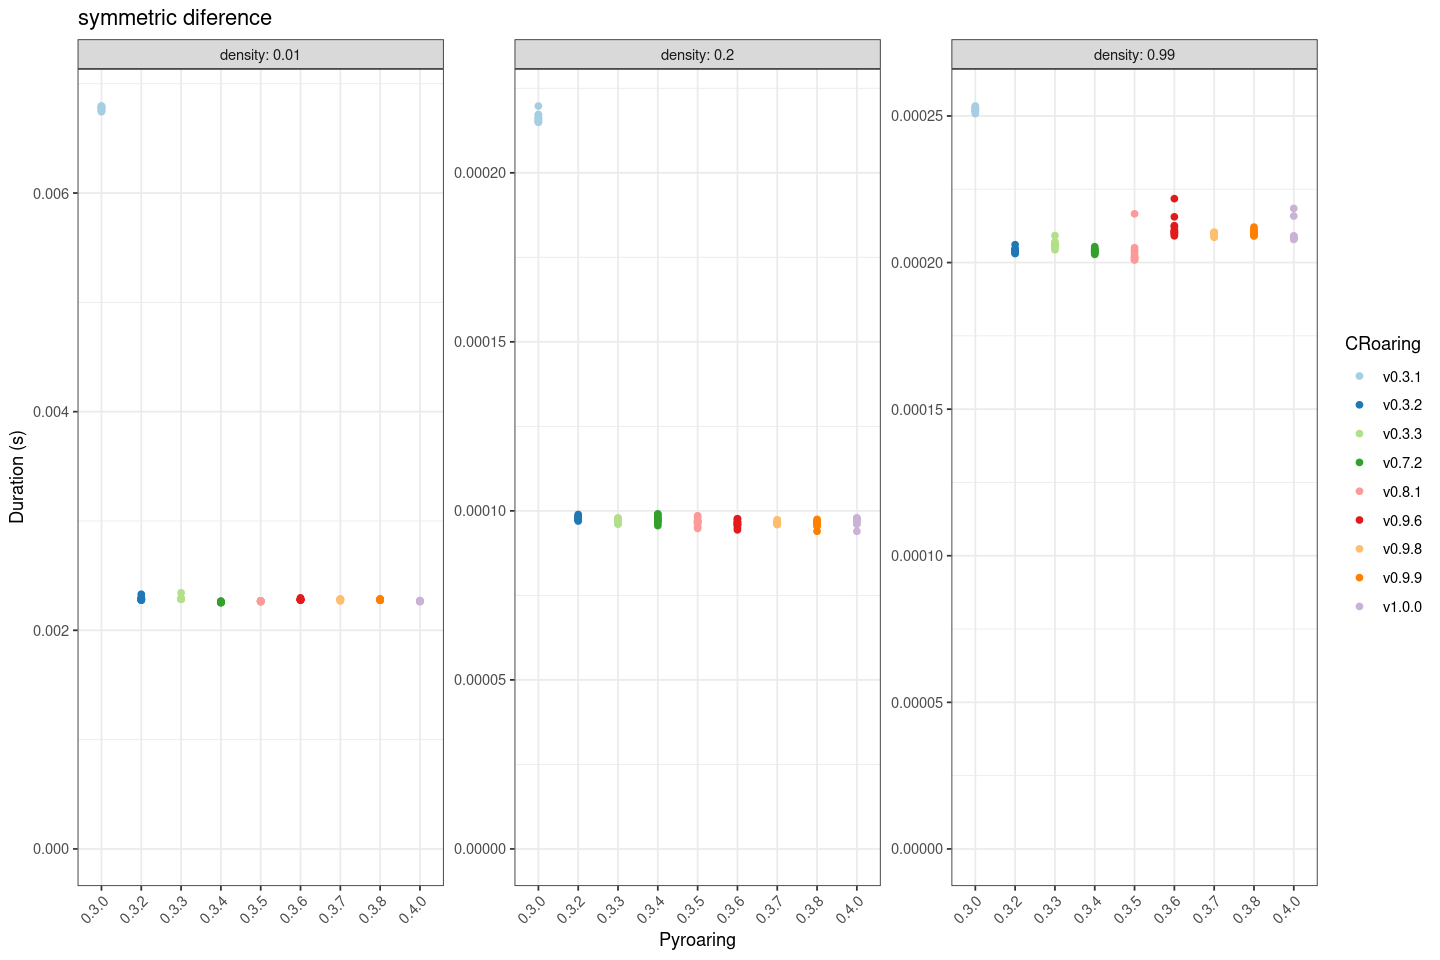

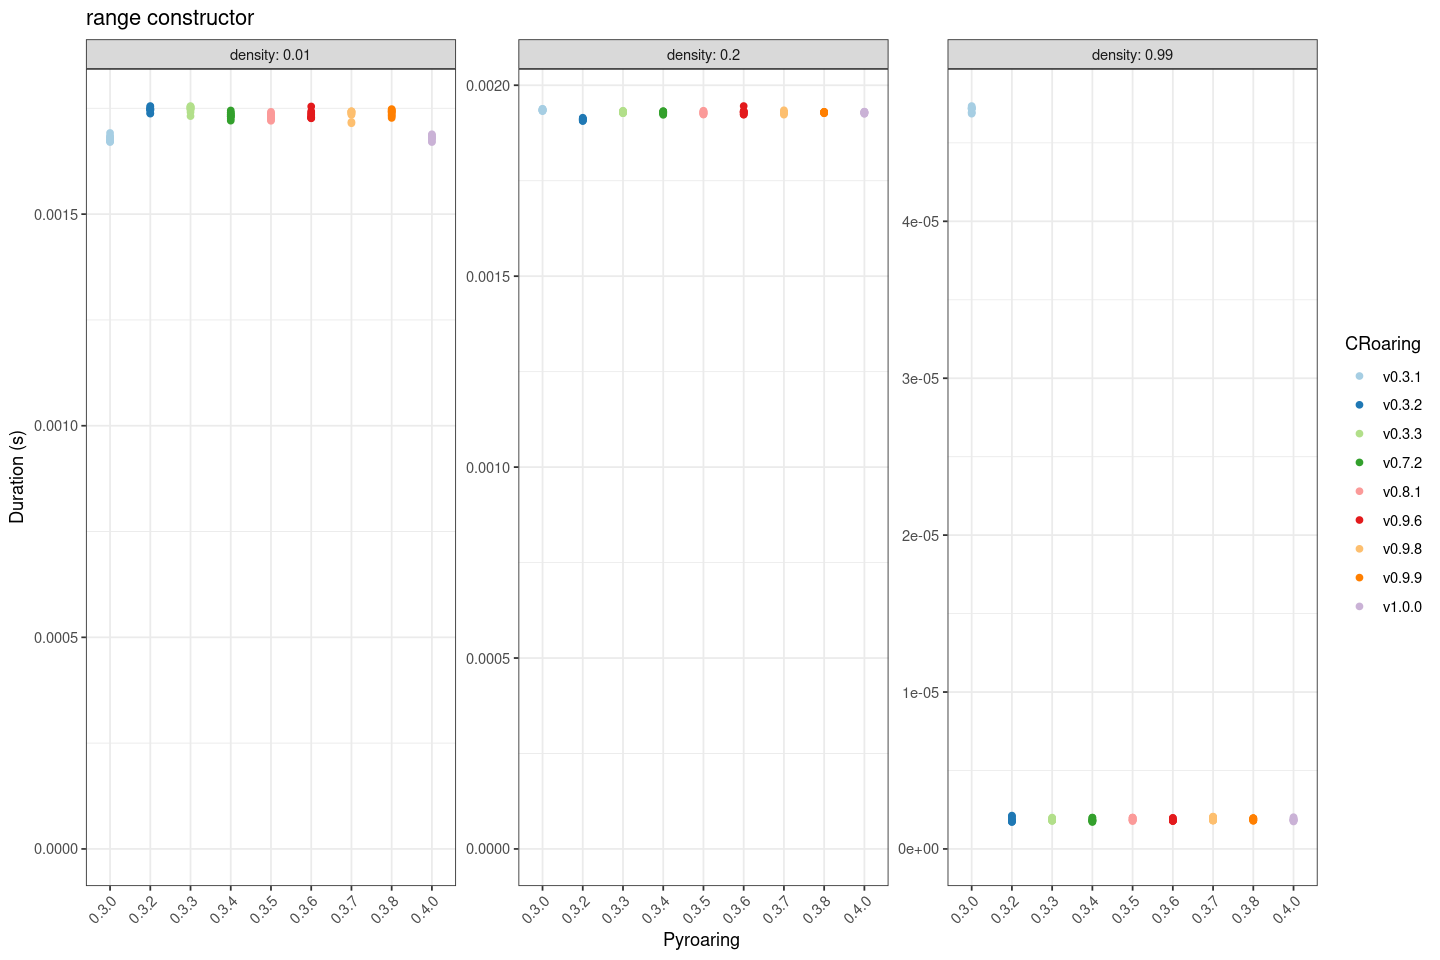

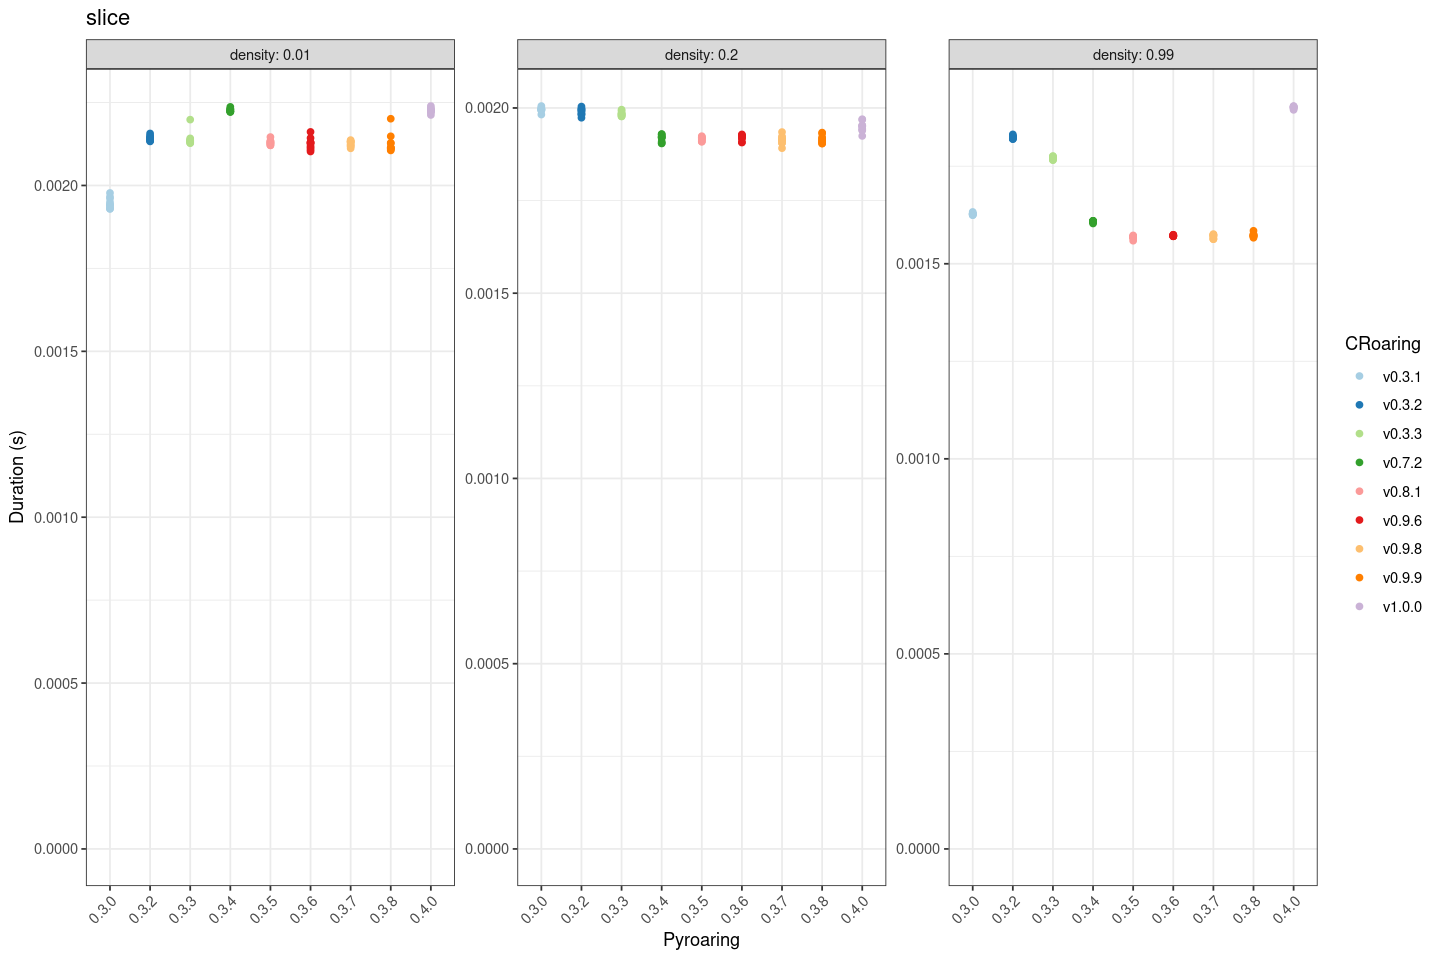

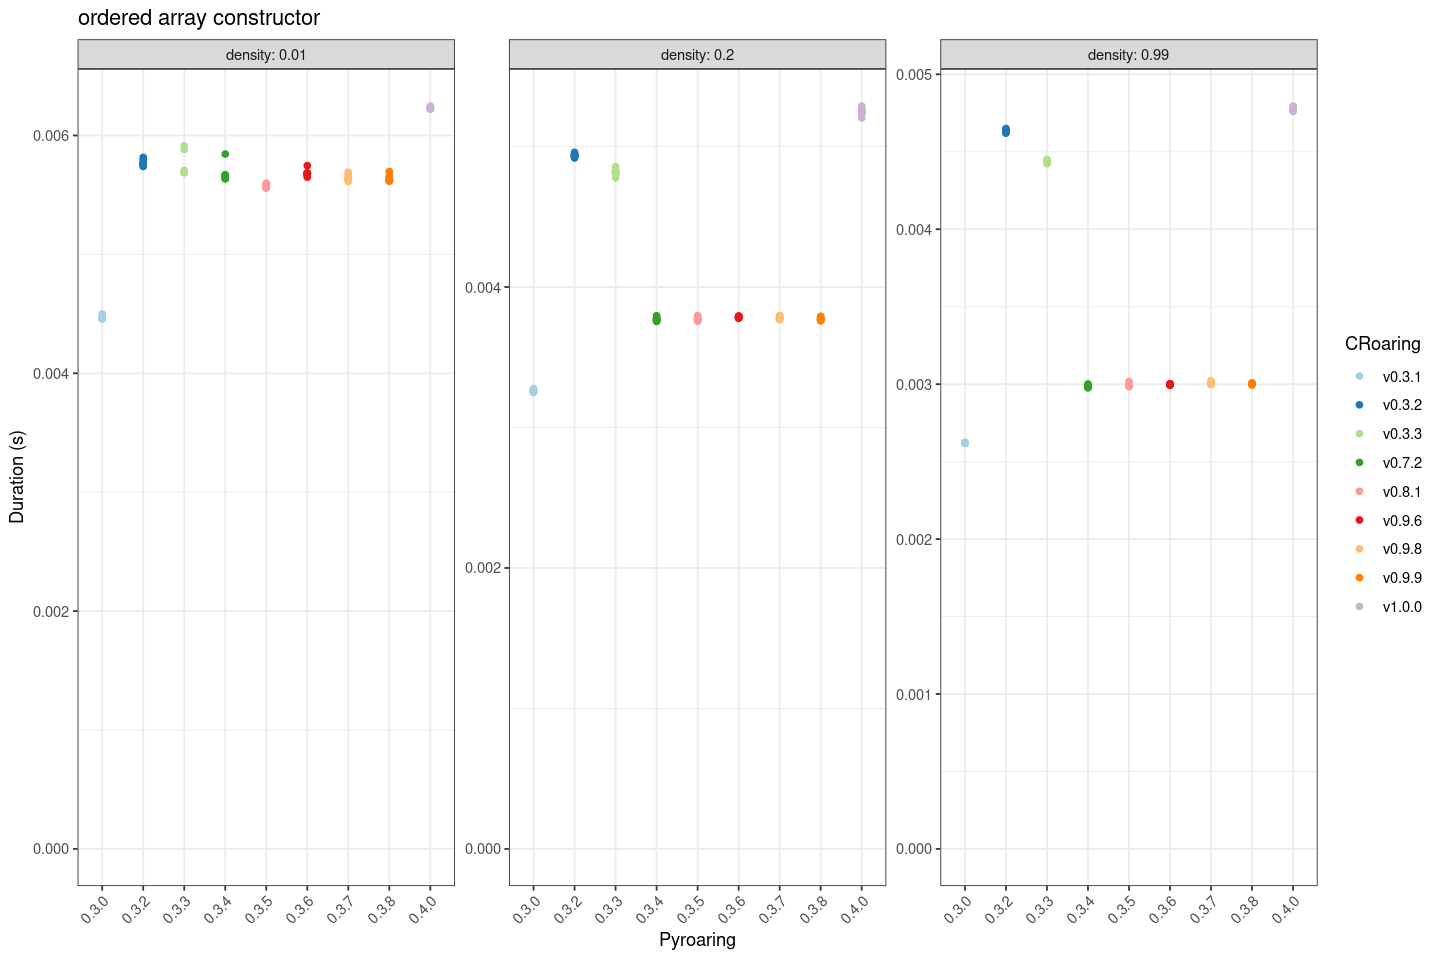

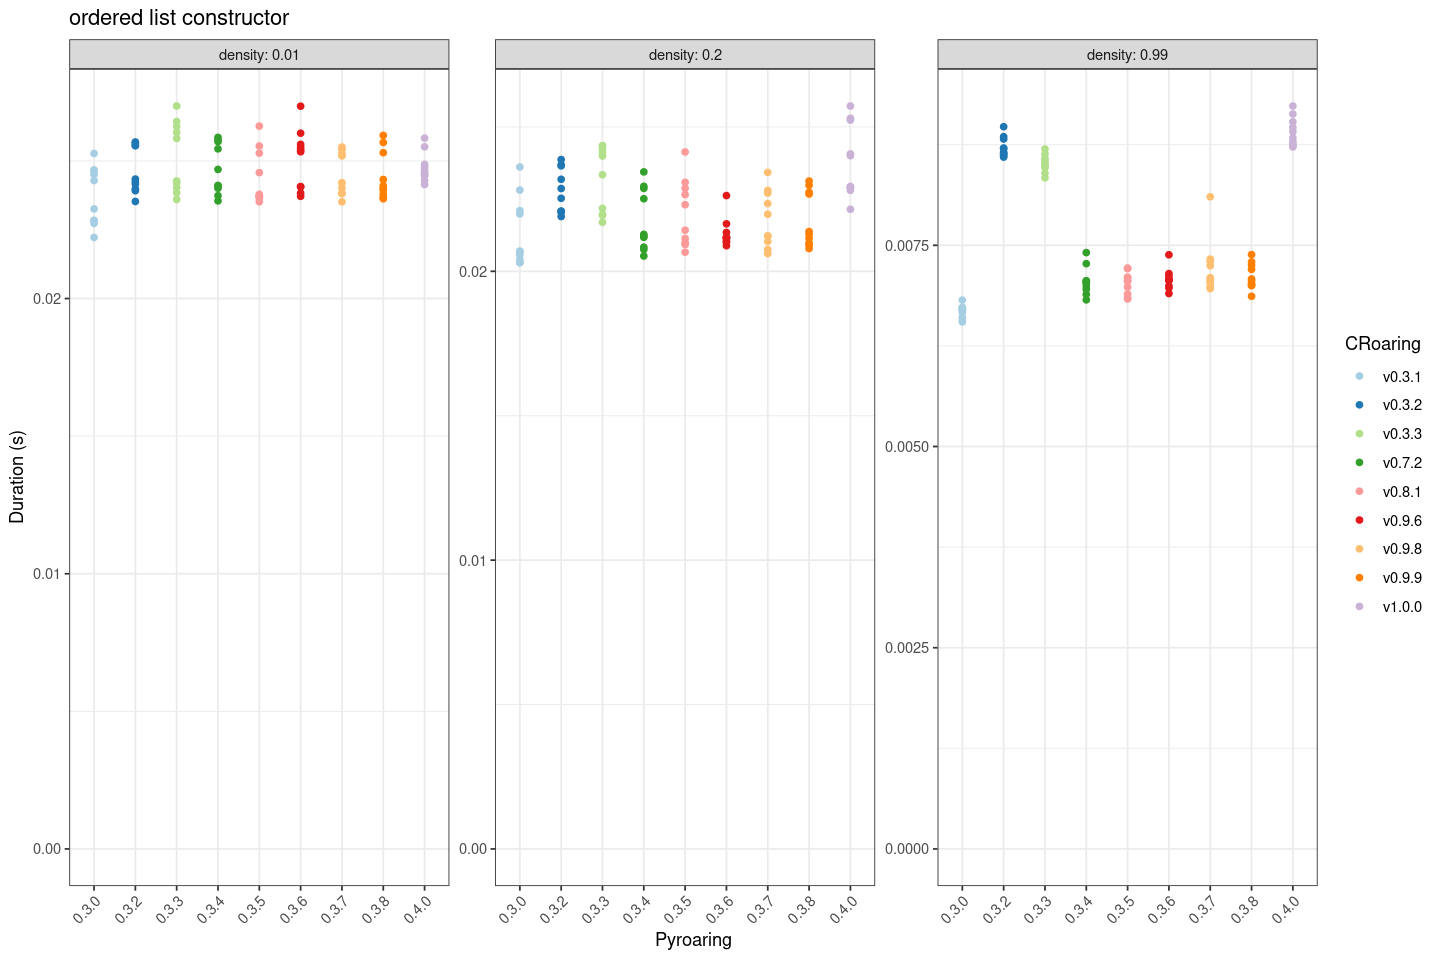

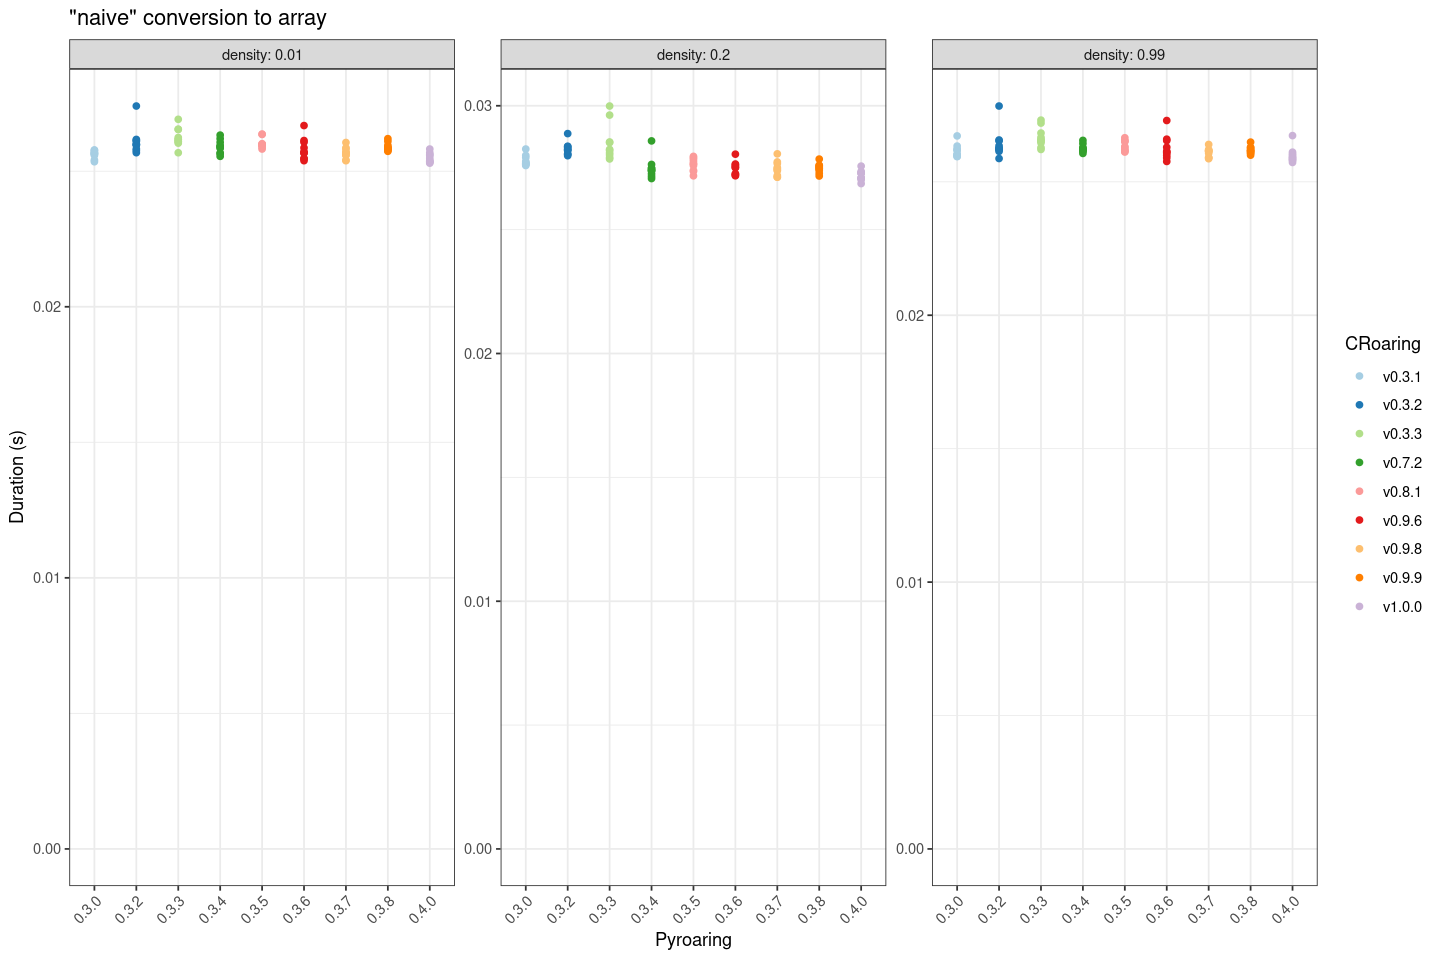

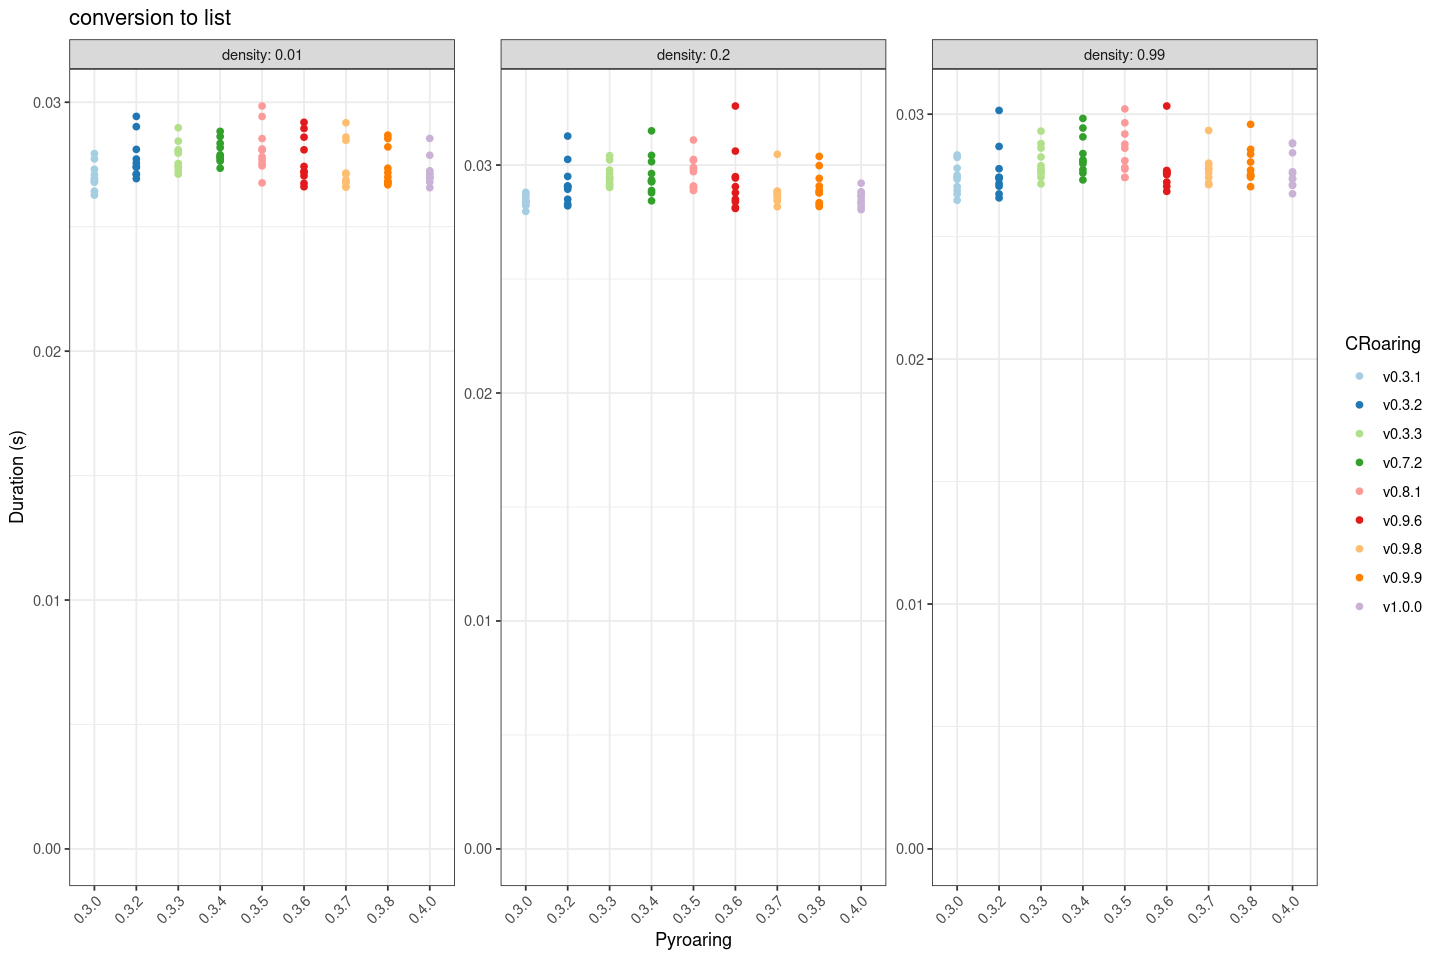

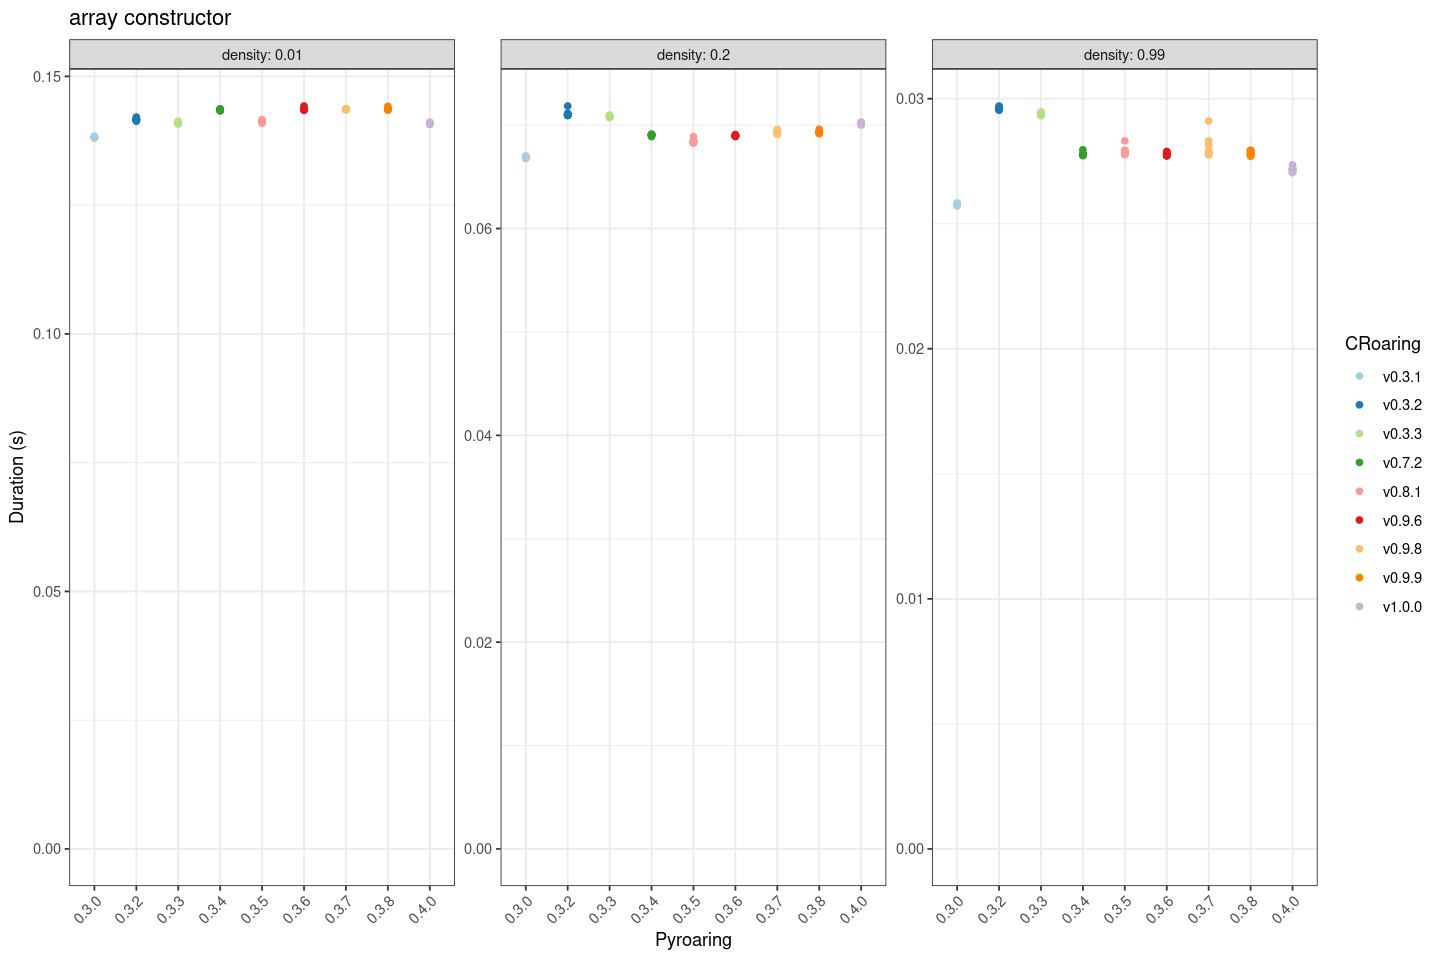

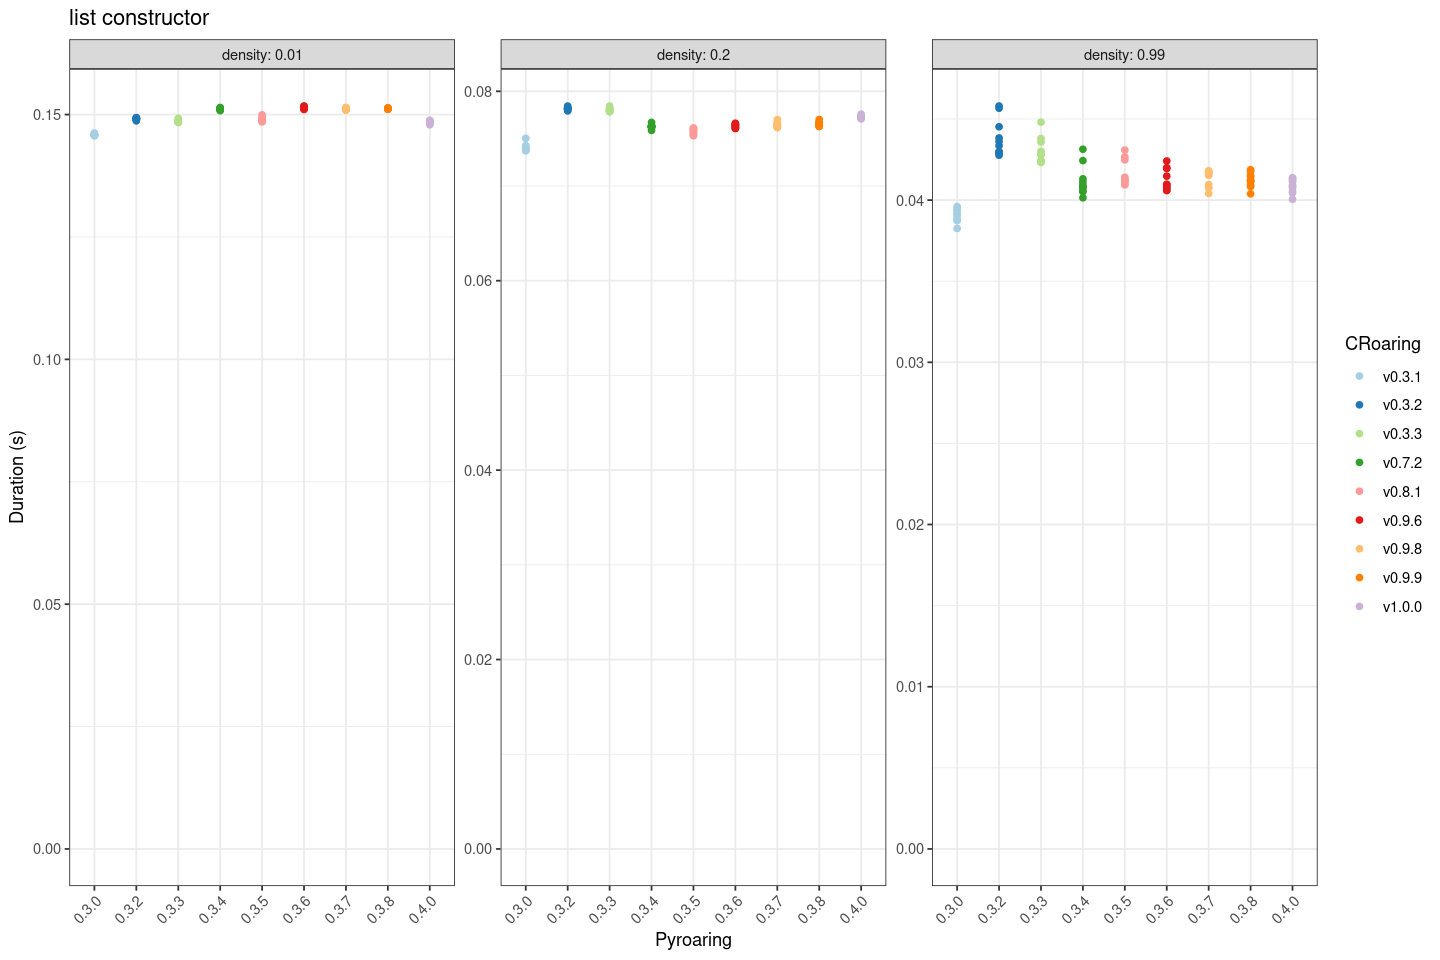

In [4]:
for(op in df %>% group_by(operation) %>% summarise(time=mean(time)) %>% arrange(time) %>% pull(operation) %>% unique()) {
    plot = df %>%
        filter(operation == op) %>%
        ggplot() +
            aes(x=pyroaring_version, y=time, color=croaring_version) +
            facet_wrap("density", scales="free", labeller="label_both") +
            # stat_summary(fun.data = "mean_cl_normal", colour = "black", geom="crossbar", fun.args=list(conf.int=.99)) +
            geom_point() +
            expand_limits(y=0) +
            theme_bw() +
            scale_color_brewer(palette="Paired") +
            theme(axis.text.x = element_text(angle = 45, hjust=1)) +
            labs(color="CRoaring") + xlab("Pyroaring") + ylab("Duration (s)") +
            ggtitle(op)
    print(plot)
}